In [1]:
#!pip install h5py

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model, load_model

from keras import initializers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD

import numpy as np
import pandas as pd
import h5py as h5py

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Load Data

In [3]:
### load data [1000, 244, 244, 3]
data_x = np.load("data_image_cnn_1000.npy")
data_y = np.load("data_genre_1000.npy")

In [4]:
### change data type
data_x = np.float16(data_x)
print (data_x.dtype)

data_y = np.int16(data_y)
print (data_y.dtype)

float16
int16


In [4]:
print(data_x.shape)
print(data_y.shape)

(1000, 224, 224, 3)
(1000, 8)


X: data_x (1000 x 224 x 224 x 3)  |  centered seperately by mean pixel of each RGB channel
   
y: data_y (1000 x 8)

### Load VGG16

In [5]:
## Get the whole VGG network trained on ImageNet

model_vgg16 = VGG16(include_top=True, weights='imagenet')
##model_vgg16 = load_model('vgg16_model_full.h5')  #the ".h5" file is huge, slow to copy to AWS

/home/ubuntu/.local/lib/python2.7/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### 1. Extract after FC2 Layer
- feature extraction

#### Extract VGG16 model after fc2:

In [6]:
## extract after fc2
model = Model(inputs=model_vgg16.input,
              outputs=model_vgg16.get_layer("fc2").output)

#### Set the layers as non-trainable

In [7]:
## set to non-trainable
for layer in model.layers[:]:
     layer.trainable = False

#### Add prediction layers

In [8]:
he = initializers.he_normal()  # initializer

#x = Flatten(name='flatten')(x) 
#x = Dense(1024, activation='relu', name='fc3', kernel_initializer=he)(model.output)
x = Dropout(0.5)(model.output)  # add one more Dropout layer
x = Dense(8, activation='sigmoid', name='predictions')(x)

## Create your own model 
mymodel = Model(inputs=model.input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


#### Train Model

In [14]:
## Parameters
lr = 0.003
momentum = 0.9
batch_size = 32
epochs = 500

In [ ]:
## learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=0.0001)

## early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', patience=10)

callbacks_list = [early_stopping, reduce_lr]

In [15]:
## train model
sgd = SGD(lr=lr, momentum=momentum)  # momentum = [0.9, 0.99]
mymodel.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

history = mymodel.fit(data_x, data_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.2,
                    callbacks = callbacks_list)

#### Visualize Result

In [ ]:
### save the model
#mymodel.save('mymodel_vgg16.h5')

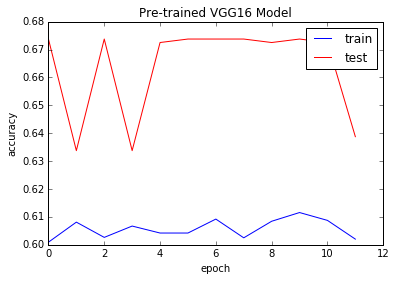

In [16]:
## plot result
plt.plot(history.history['acc'], color = 'blue', label = 'train')
plt.plot(history.history['val_acc'], color = 'red', label = 'test')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title('Pre-trained VGG16 Model')
plt.show()

### 2. Train from deeper layer

In [6]:
## extract after block4
model2 = Model(inputs=model_vgg16.input,
              outputs=model_vgg16.get_layer("block4_pool").output)

## set to non-trainable
for layer in model2.layers[:]:
     layer.trainable = False

In [7]:
he = initializers.he_normal()  # add initializer

x = Conv2D(512, 3, 3, activation='relu', kernel_initializer=he, name = "block5_conv1")(model2.output)
x = Dropout(0.5)(x) # add extra dropout layer
x = Conv2D(512, 3, 3, activation='relu', kernel_initializer=he, name = "block5_conv2")(x)
x = Conv2D(512, 3, 3, activation='relu', kernel_initializer=he, name = "block5_conv3")(x)
x = MaxPooling2D((2,2), strides=(3,3), name = "block5_pool")(x)
x = Dropout(0.5)(x) # add extra dropout layer
x = Flatten()(x)
x = Dense(1024, activation='relu', name='fc1', kernel_initializer=he)(x)
x = Dropout(0.5)(x) # add one more dropout layer
x = Dense(256, activation='relu', name='fc2', kernel_initializer=he)(x)
x = Dense(8, activation='sigmoid', name='predictions')(x)

## Create your own model 
mymodel2 = Model(inputs=model2.input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
mymodel2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu", kernel_initializer=<keras.ini..., name="block5_conv1")`
  app.launch_new_instance()
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu", kernel_initializer=<keras.ini..., name="block5_conv2")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu", kernel_initializer=<keras.ini..., name="block5_conv3")`
/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


#### Train Model

In [14]:
## Parameters
lr = 0.001
momentum = 0.9
batch_size = 32
epochs = 100

In [15]:
## learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, min_lr=0.0001)

## early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_acc', patience=20)

callbacks_list = [early_stopping, reduce_lr]

In [16]:
## train model
sgd = SGD(lr=lr, momentum=momentum)  # momentum = [0.9, 0.99]
mymodel2.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

history2 = mymodel2.fit(data_x, data_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.2,
                    callbacks = callbacks_list)

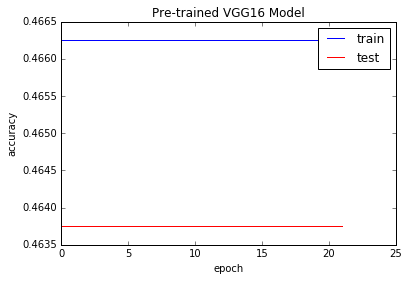

In [17]:
## plot result
plt.plot(history2.history['acc'], color = 'blue', label = 'train')
plt.plot(history2.history['val_acc'], color = 'red', label = 'test')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title('Pre-trained VGG16 Model')
plt.show()

Questions:
- what to tune? (lr is already low)
- useful for project?
- what's an optimal accuracy plot?
- extract from which layer (usually)? how good it generalizes? 